## Normalizing Flows

Your task is to implement a version of Normalizing Flow for image generation. Our implementation will be based on RealNVP (https://arxiv.org/pdf/1605.08803.pdf) and we will be training on one class from MNIST. Your task is to read the paper in details and implement simple version of the algorithm from the paper:


1. Implement simple CouplingLayers (see RealNVP paper) with neural networks using a few fully connected layers with hidden activations of your choice. More on the CouplingLayers can be also found in https://arxiv.org/pdf/1410.8516.pdf. Remember to implement properly logarithm of a Jacobian determinant calculation. Implement only single scale architecture, ignore multiscale architecture with masked convolution and batch normalization. (2 points)
2. Implement RealNVP class combining many CouplingLayers with proper masking pattern (rememeber to alternate between unmodified pixels) with forward and inverse flows. (1 points)
3. Implement a loss function `nf_loss` (data log-likelihood) for the model. Hint: check `torch.distributions` (1 point)
4. Train your model to achieve good looking samples (similar to training set) and average per sample likelihood on training set lower than -1700. (2 points)
5. Sample from your model and pick 2 images (as visually different as possible) from your samples and plot 10 images that correspond to equally spaced linear interpolations in latent space between those images you picked. (1 point)
6. Use method from section 5.2 from https://arxiv.org/pdf/1410.8516.pdf with trained model and inpaint 5 sampled images with different random parts of your image occluded (50% of the image must be occluded). (2 point)
7. Write a report describing your solution, add loss plots and samples from the model. Write which hyperparameter sets worked for you and which did not. (1 point)

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
INPUT_SIZE = 28 * 28


class MLP(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, in_features),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.layers(x)


class CouplingLayer(nn.Module):        
    def __init__(self, in_features, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.net_t = MLP(in_features // 2)
        self.net_s = MLP(in_features // 2)
 
    def forward_flow(self, x):
        x1, x2 = x

        s = self.net_s(x1)
        t = self.net_t(x1)

        x2 = x2 * torch.exp(s) + t
        logdet_j = s.sum(dim=1)

        return [x2, x1], logdet_j
    
    def inverse_flow(self, z):
        z1, z2 = z

        s = self.net_s(z1)
        t = self.net_t(z1)

        z2 = (z2 - t) * torch.exp(-s)

        return [z2, z1]
    
    
class RealNVP(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            CouplingLayer(INPUT_SIZE) 
            for i in range(10)
        ])
    
    def forward_flow(self, x):
        logdet_j = torch.zeros(x.shape[0]).to(device)
        x = x.view(x.shape[0], -1).chunk(2, dim=1)

        for layer in self.layers:
            x, logdet_j_ = layer.forward_flow(x)
            logdet_j += logdet_j_

        x = torch.cat(x, dim=1)

        return x.view(x.shape[0], 28, 28), logdet_j
    
    def inverse_flow(self, z):
        z = z.view(z.shape[0], -1).chunk(2, dim=1)

        for layer in reversed(self.layers):
            z = layer.inverse_flow(z)

        z.reverse()
        z = torch.cat(z, dim=1)

        return z.view(z.shape[0], 28, 28)

    def sample(self, num_samples):
        sample_noise = torch.randn(num_samples, 28, 28).to(device)
        with torch.no_grad():
            self.eval()
            return model.inverse_flow(sample_noise), sample_noise
        
        
def nf_loss(z, logdet_j):
    dist = torch.distributions.normal.Normal(0, 1)
    log_pz = dist.log_prob(z).sum(dim=[1, 2])
    log_px = log_pz + logdet_j
    nll = -log_px.mean()
    return nll

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = torchvision.datasets.MNIST(root=r'./mnist/', 
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)
x = (dataset.data.float() / 255. - 0.5)
y = dataset.targets
x = x[y == 5]

dataloader = DataLoader(x, batch_size=1024, shuffle=True)

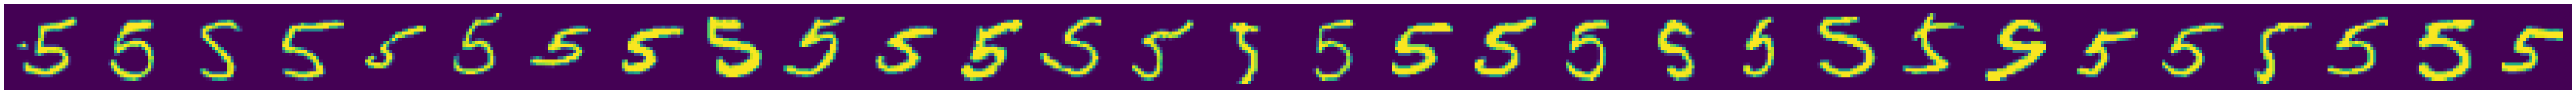

In [ ]:
def plot(samples):
    length = len(samples)
    fig, ax = plt.subplots(1, length, figsize=(2*length, 2))
    fig.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    for j in range(length):
        ax[j].imshow(samples[j].cpu().numpy())
        ax[j].axis('off')
    plt.show()

plot(next(iter(dataloader))[:30])

In [ ]:
path = 'real_nvp.ckpt'
n_epochs = 500
lr = 5e-4

model = RealNVP().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Epoch: 1/500 Loss: 561.7774


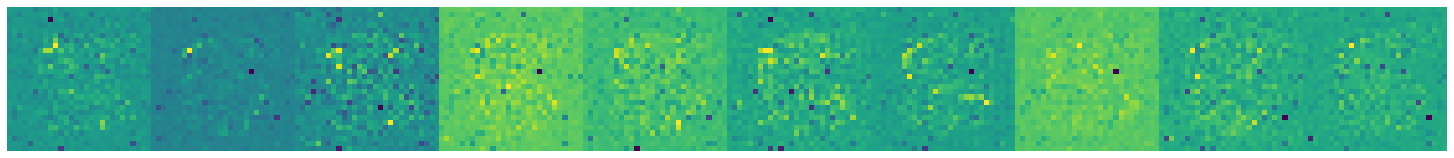

Epoch: 11/500 Loss: -1297.9949


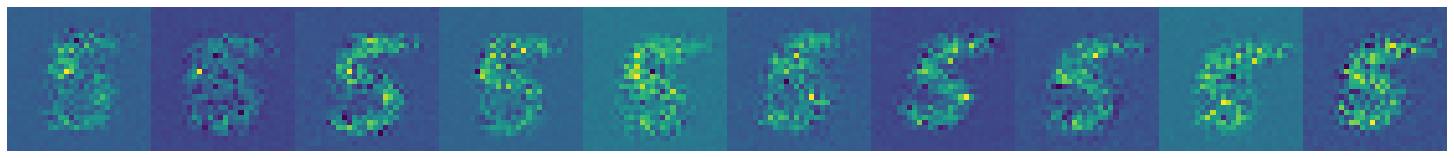

Epoch: 21/500 Loss: -1484.9556


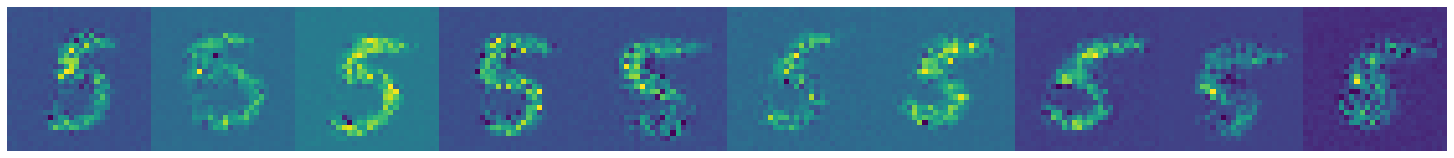

Epoch: 31/500 Loss: -1561.4874


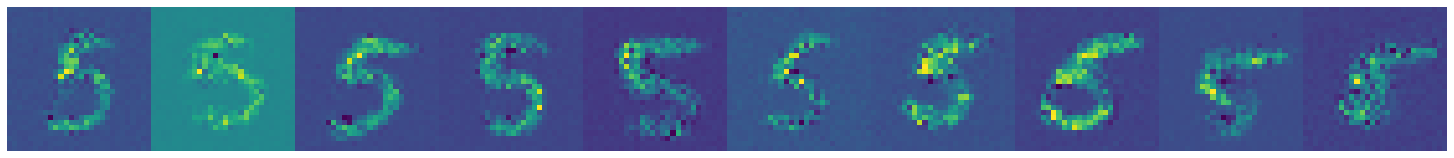

Epoch: 41/500 Loss: -1607.2231


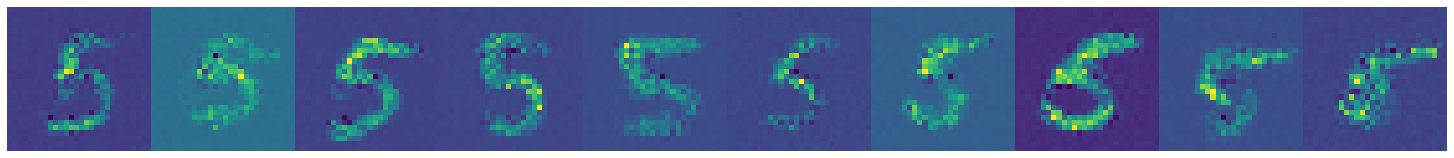

Epoch: 51/500 Loss: -1634.0543


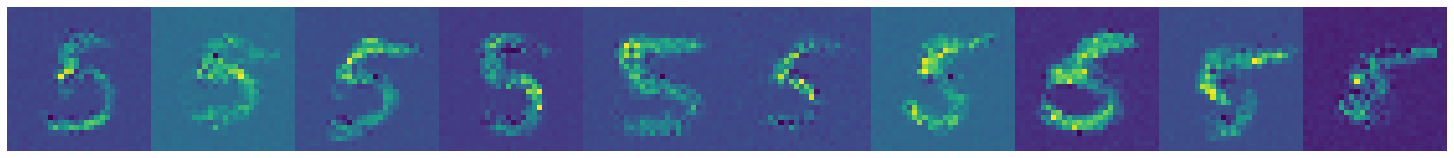

Epoch: 61/500 Loss: -1658.8388


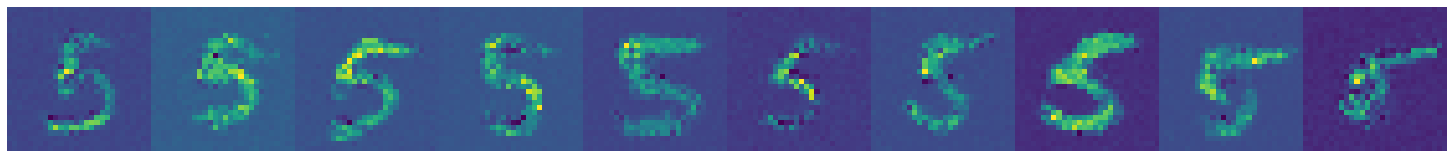

Epoch: 71/500 Loss: -1670.9311


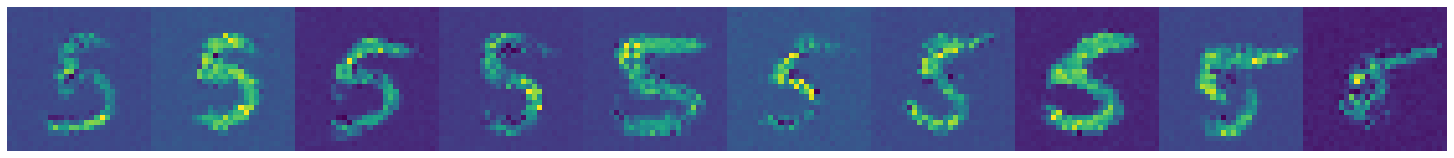

Epoch: 81/500 Loss: -1692.0892


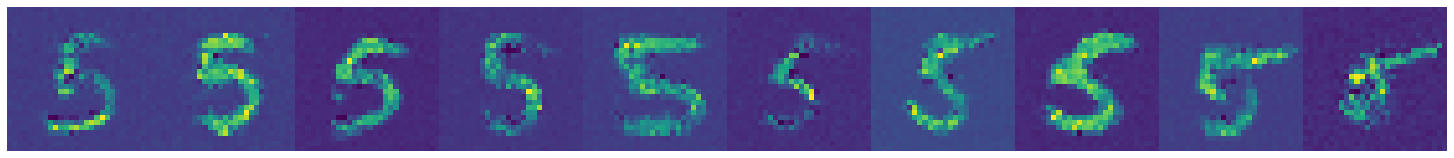

Epoch: 91/500 Loss: -1706.1261


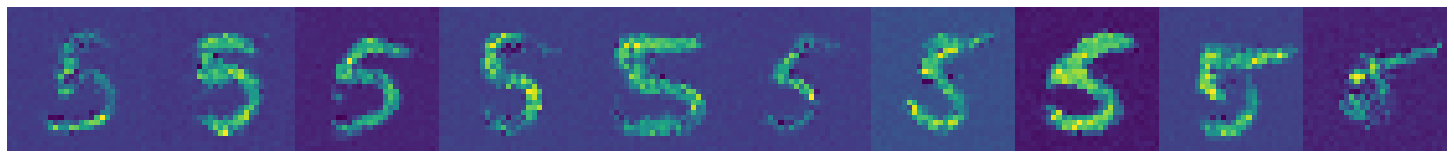

Epoch: 101/500 Loss: -1713.8453


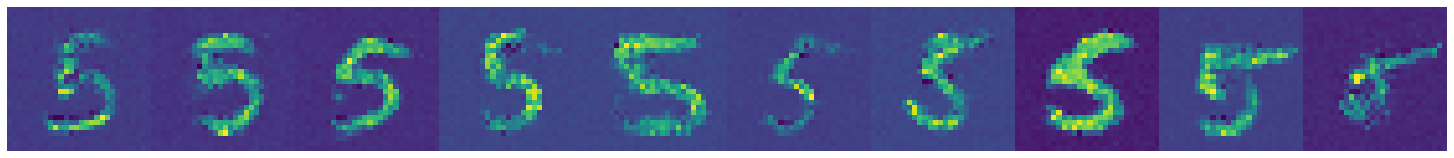

Epoch: 111/500 Loss: -1727.1090


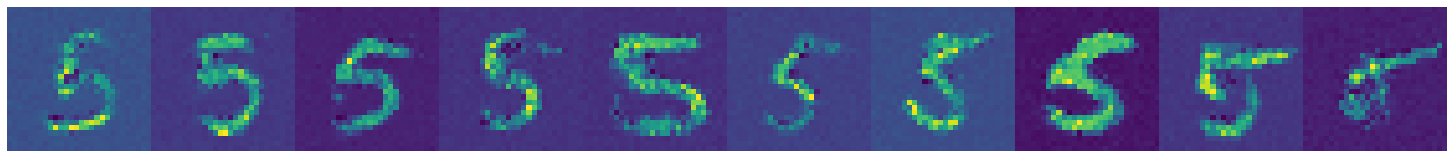

Epoch: 121/500 Loss: -1724.1080


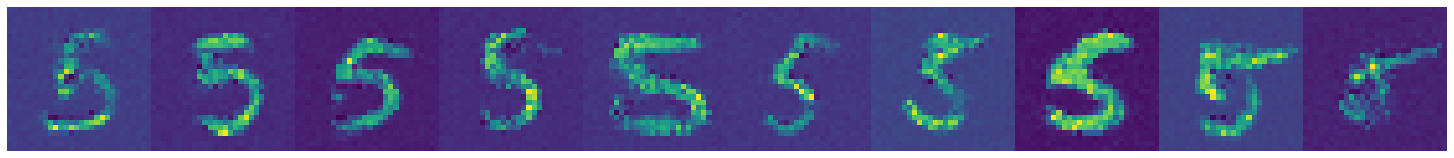

Epoch: 131/500 Loss: -1736.9787


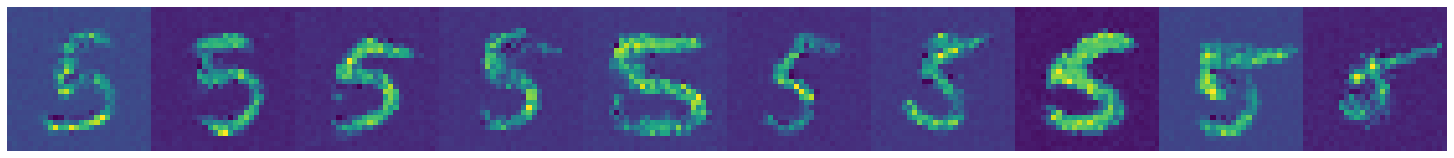

Epoch: 141/500 Loss: -1747.2294


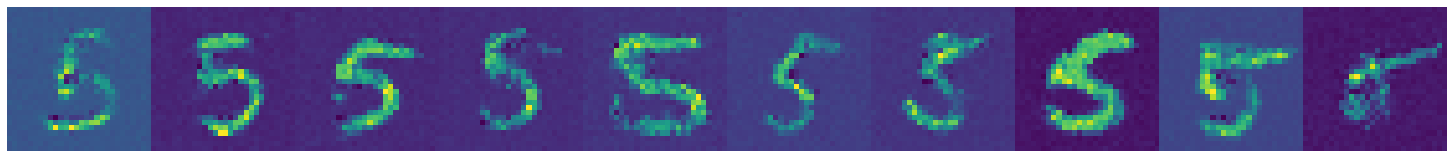

Epoch: 151/500 Loss: -1750.9128


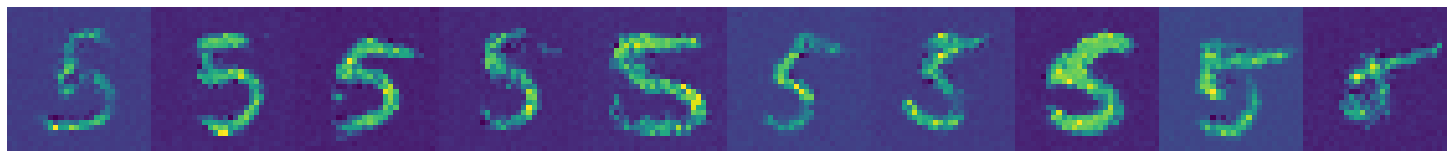

Epoch: 161/500 Loss: -1755.1232


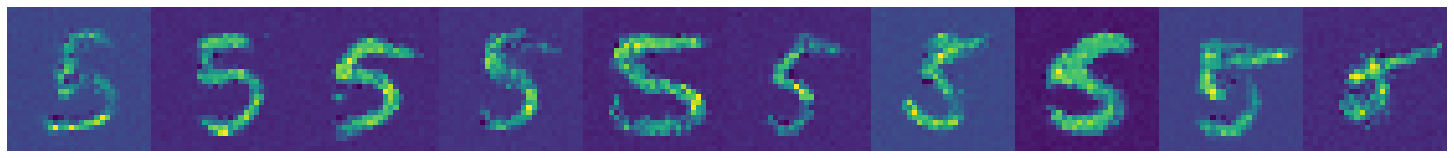

Epoch: 171/500 Loss: -1759.9944


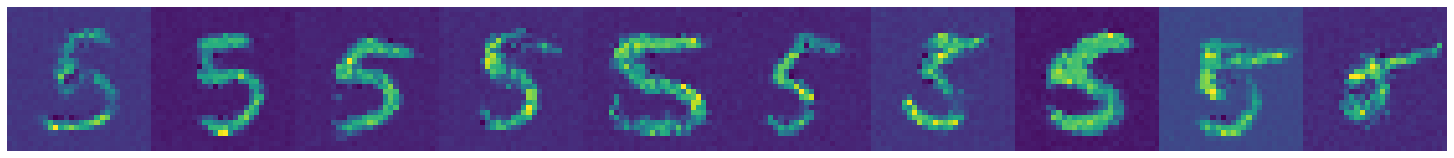

Epoch: 181/500 Loss: -1773.4538


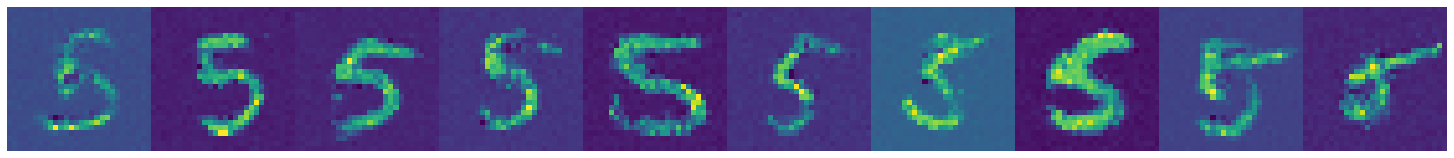

Epoch: 191/500 Loss: -1773.4261


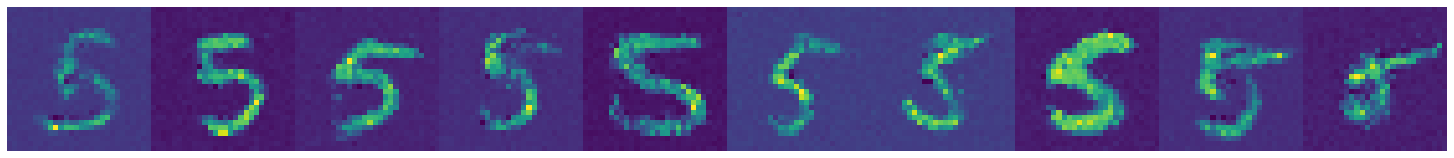

Epoch: 201/500 Loss: -1779.0499


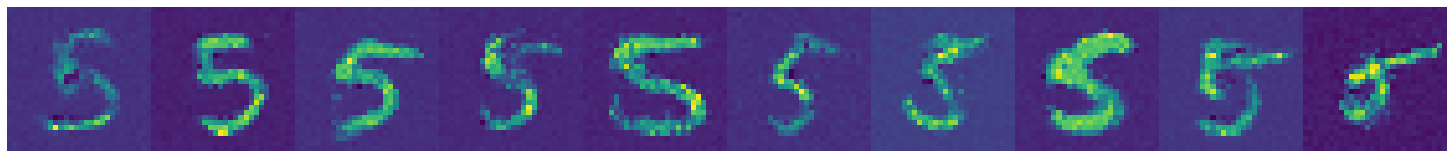

Epoch: 211/500 Loss: -1772.7452


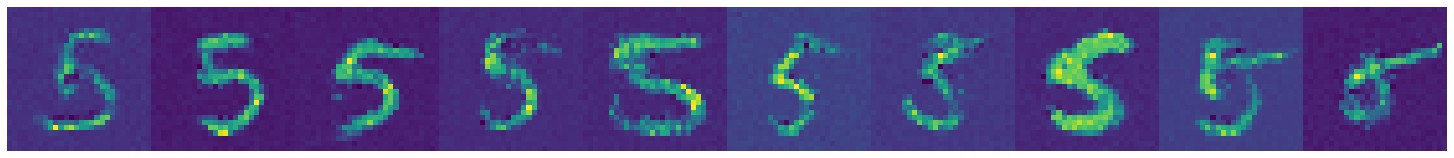

Epoch: 221/500 Loss: -1791.9610


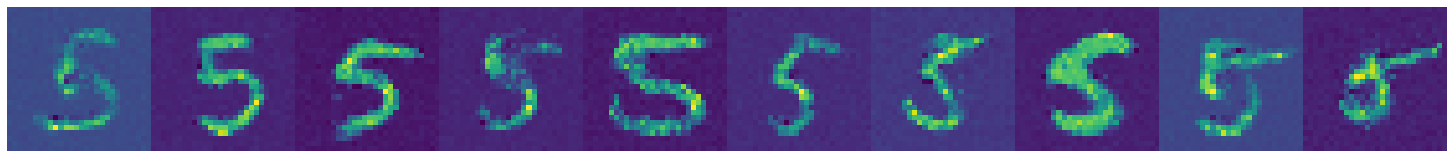

Epoch: 231/500 Loss: -1796.7746


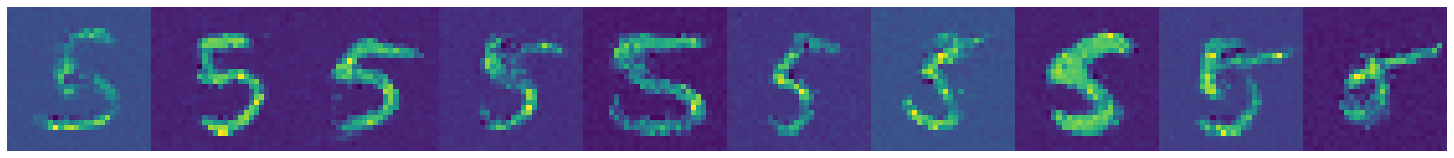

Epoch: 241/500 Loss: -1800.4917


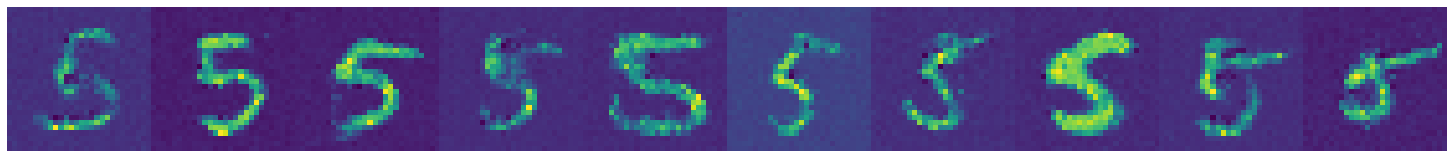

Epoch: 251/500 Loss: -1800.2210


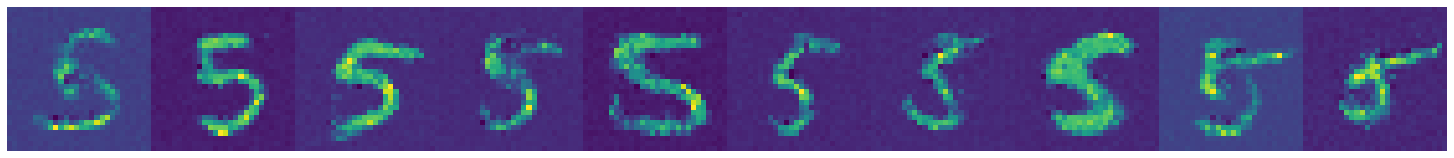

Epoch: 261/500 Loss: -1807.7510


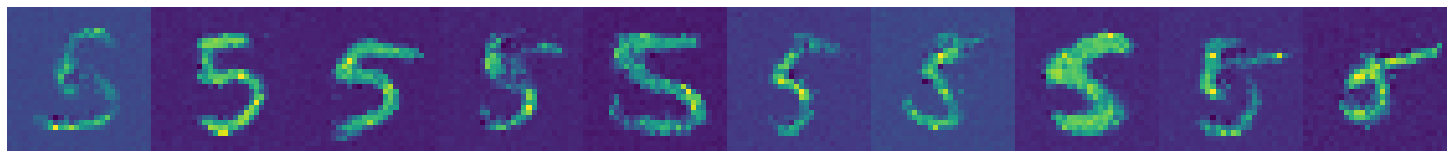

Epoch: 271/500 Loss: -1815.0723


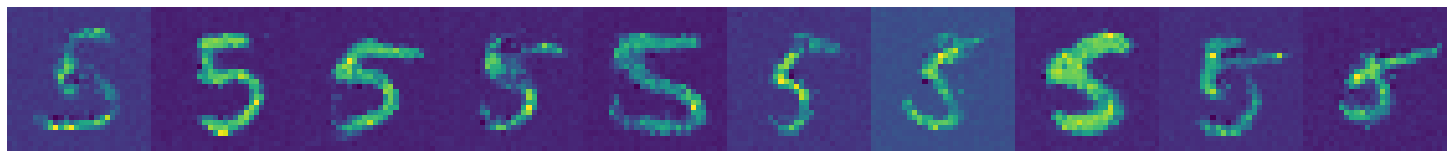

Epoch: 281/500 Loss: -1814.3115


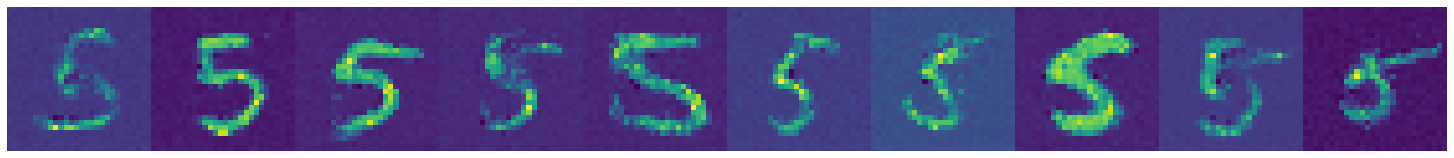

Epoch: 291/500 Loss: -1819.4095


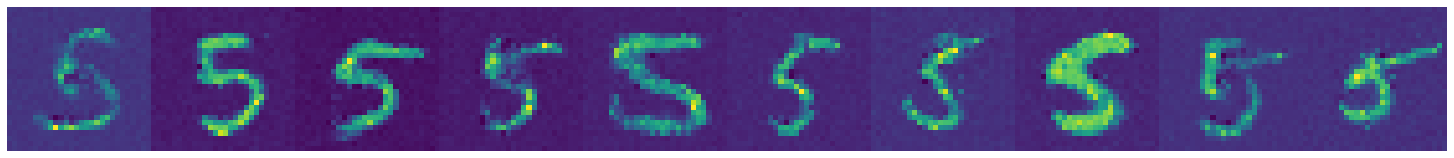

Epoch: 301/500 Loss: -1821.1310


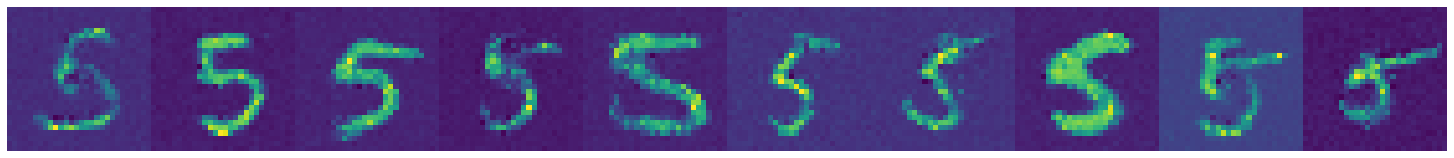

Epoch: 311/500 Loss: -1827.9270


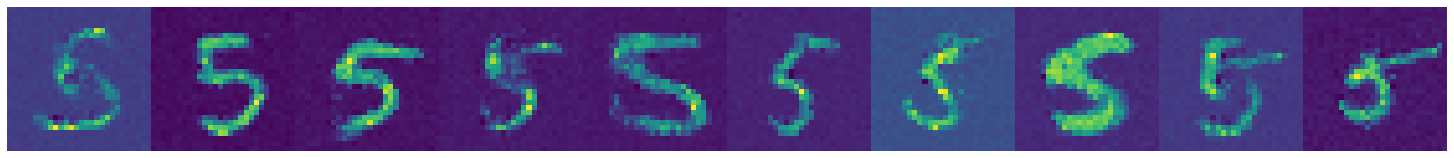

Epoch: 321/500 Loss: -1827.9691


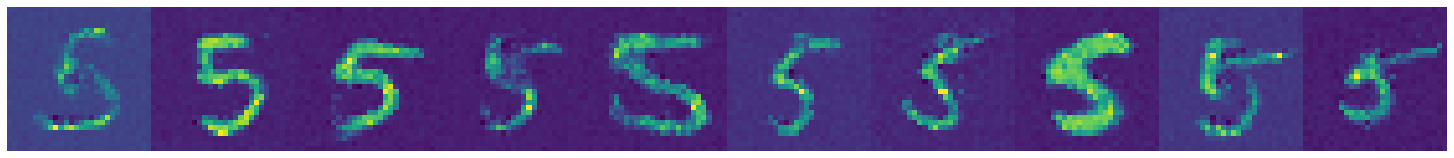

Epoch: 331/500 Loss: -1836.1259


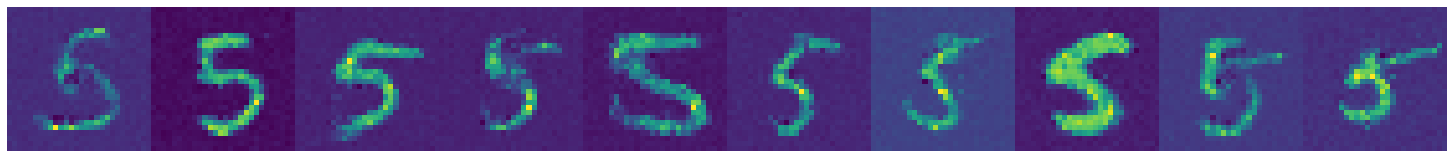

Epoch: 341/500 Loss: -1835.8268


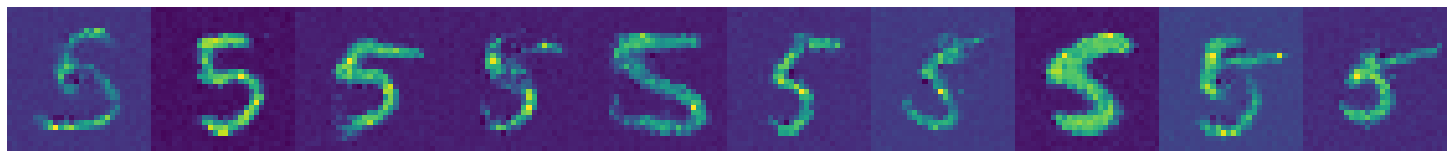

Epoch: 351/500 Loss: -1831.0609


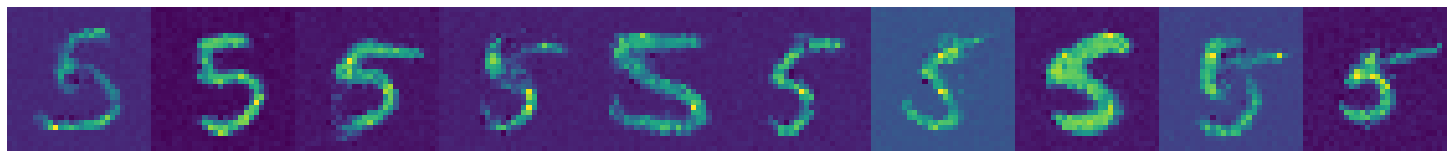

Epoch: 361/500 Loss: -1841.9137


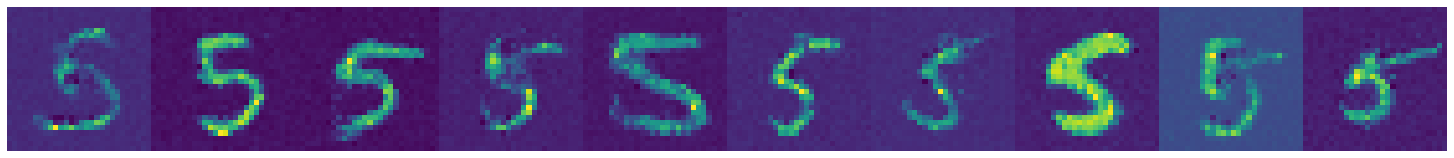

Epoch: 371/500 Loss: -1844.5272


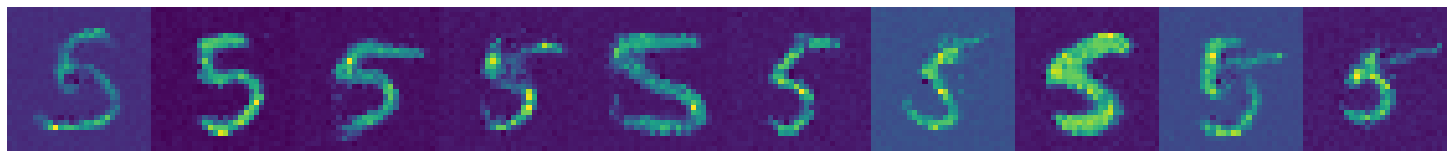

Epoch: 381/500 Loss: -1845.0332


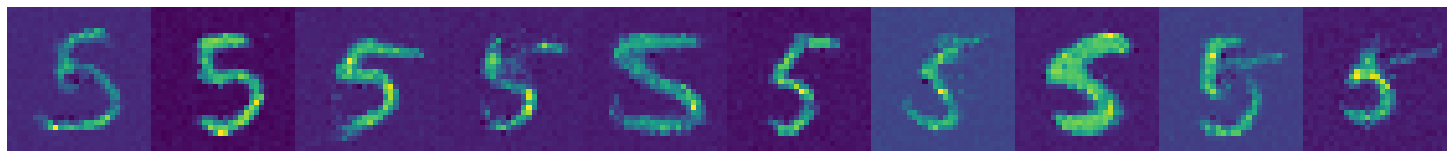

Epoch: 391/500 Loss: -1847.6438


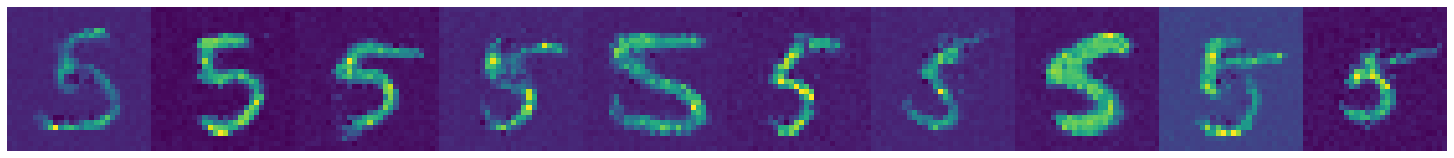

Epoch: 401/500 Loss: -1852.1671


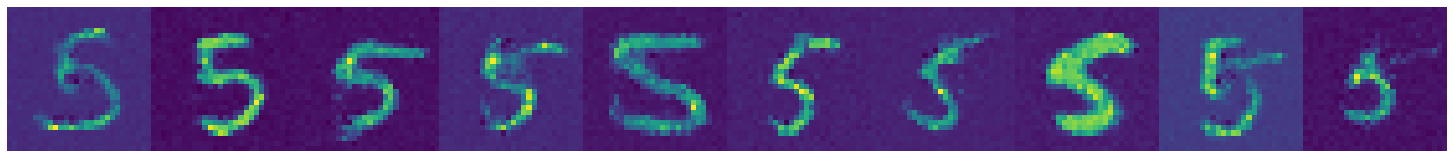

Epoch: 411/500 Loss: -1851.0018


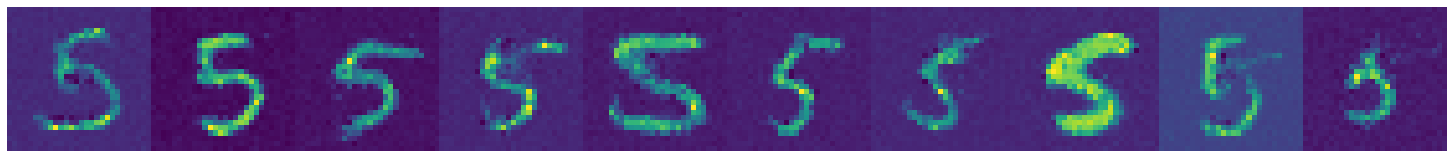

Epoch: 421/500 Loss: -1852.1514


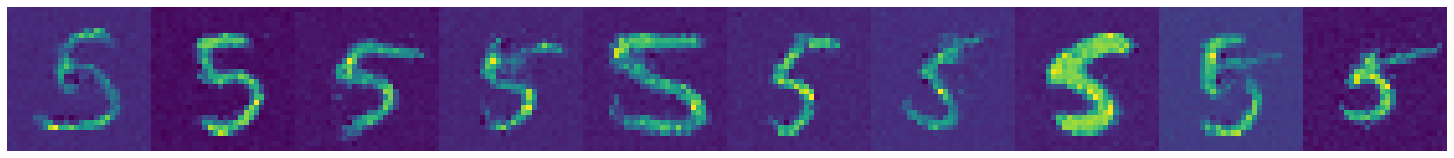

Epoch: 431/500 Loss: -1859.0751


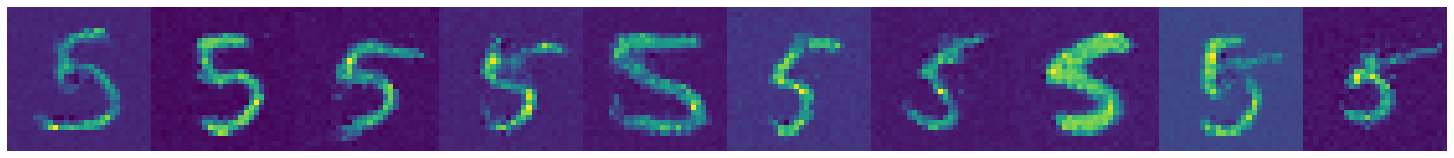

Epoch: 441/500 Loss: -1853.5669


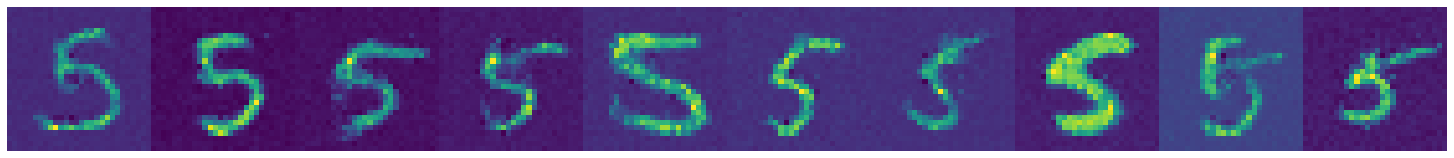

Epoch: 451/500 Loss: -1858.6961


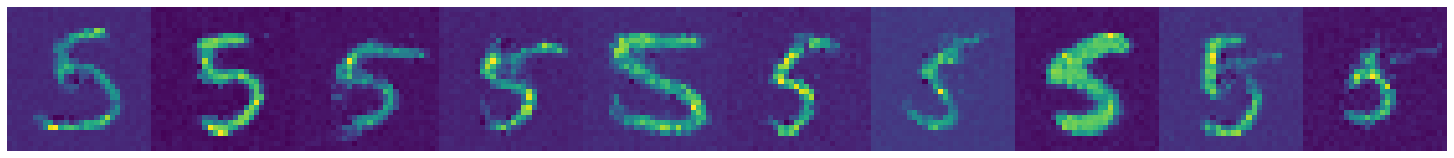

Epoch: 461/500 Loss: -1865.4358


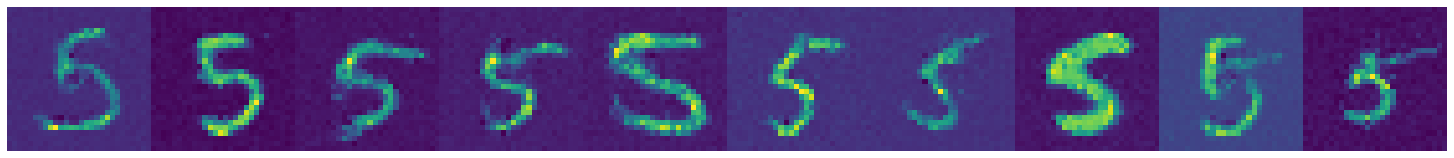

Epoch: 471/500 Loss: -1864.5737


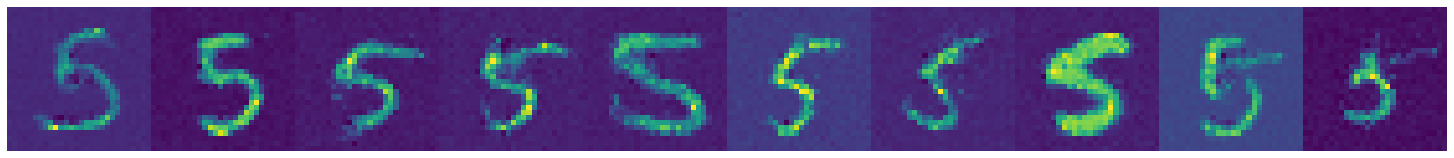

Epoch: 481/500 Loss: -1869.4169


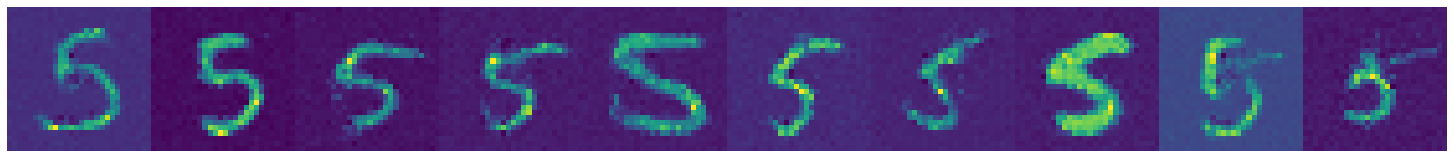

Epoch: 491/500 Loss: -1868.3942


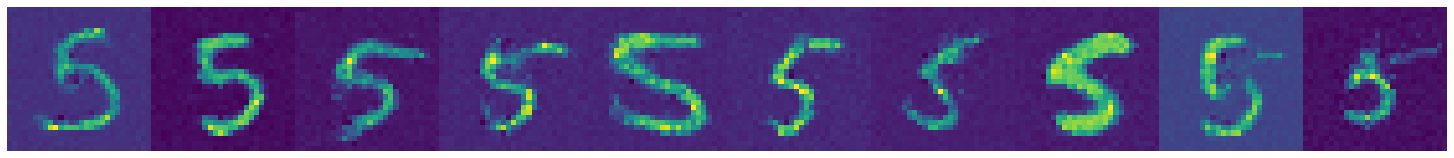

In [ ]:
sample_noise = torch.randn(10,28,28).to(device)
loss_per_epoch = []

for i in range(n_epochs):
    model.train()
    loss_acc = 0
    for j, x in enumerate(dataloader):
        optimizer.zero_grad()
        x = (x.float() + torch.randn(x.shape) / 64.).to(device)
        z, logdet_j = model.forward_flow(x)
        loss = nf_loss(z, logdet_j)
        loss_acc += loss.item()
        loss.backward()
        optimizer.step()
    
    if i % 10 == 0:
        print(f'Epoch: {i + 1}/{n_epochs} Loss: {(loss_acc / (j+1)):.4f}')
        loss_per_epoch.append(loss_acc / (j+1))
        with torch.no_grad():
            model.eval()
            samples = model.inverse_flow(sample_noise)
            plot(samples)

In [ ]:
torch.save(model.state_dict(), path)

In [ ]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Sample images for interpolation

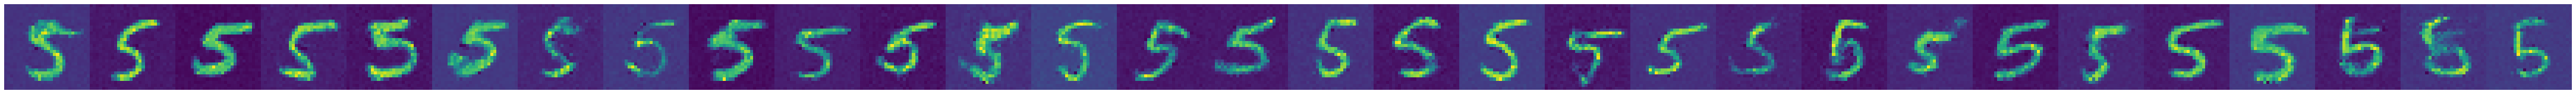

In [ ]:
samples, samples_noise = model.sample(30)
plot(samples)

## Interpolation

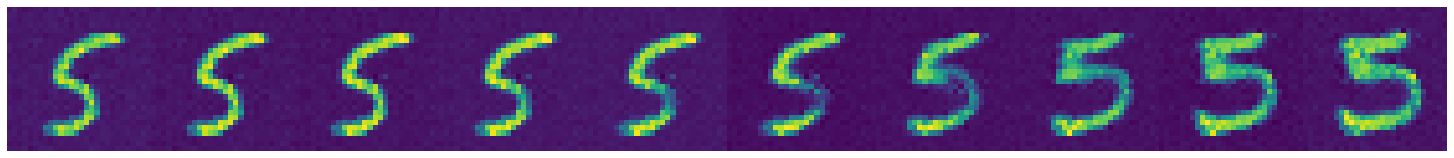

In [ ]:
def interpolate_between_images(img_noise1, img_noise2, steps=10):
	ratios = torch.linspace(0, 1, steps=steps)
	interp_noises = []
	for ratio in ratios:
		interp_noises.append((1.0 - ratio) * img_noise1 + ratio * img_noise2)
	
	with torch.no_grad():
		model.eval()
		interpolations = model.inverse_flow(torch.stack(interp_noises))
	
	return interpolations

interpolations = interpolate_between_images(
	torch.unsqueeze(samples_noise[1], axis=0), 
	torch.unsqueeze(samples_noise[4], axis=0)
)
plot(interpolations)

## Inpaint images

In [ ]:
def occlude(samples, occ_dim):
    occluded = samples.detach().clone()
    rand_noise = torch.clamp(
        torch.randn(samples.shape[0], occ_dim[2], occ_dim[3]).to(device), 
        min=-0.5, max=0.5)
    occluded[:, occ_dim[0]:occ_dim[0]+occ_dim[2], occ_dim[1]:occ_dim[1]+occ_dim[3]] = rand_noise
    return occluded


def inpaint(occluded, occ_dim, cat_chunk_dim, inverse):
    n_epochs = 4000

    xo, xh = list(reversed(occluded.chunk(2, dim=cat_chunk_dim))) if inverse else \
             occluded.chunk(2, dim=cat_chunk_dim)
    xh.requires_grad = True
    optimizer = torch.optim.SGD([xh], lr=1e-4)
        
    for i in range(n_epochs):
        optimizer.zero_grad()
        x = torch.cat([xh, xo], dim=cat_chunk_dim) if inverse else \
            torch.cat([xo, xh], dim=cat_chunk_dim)
        z, logdet_j = model.forward_flow(x)
        loss = nf_loss(z, logdet_j)
        loss.backward()
        optimizer.step()
        if (i + 1) % 1000 == 0:
            print(f'Epoch: {i + 1}/{n_epochs} Loss: {loss:.4f}')
            plot(x.detach().clone()) 

    x = torch.cat([xh, xo], dim=cat_chunk_dim) if inverse else \
        torch.cat([xo, xh], dim=cat_chunk_dim)

    return x.detach()

Take 5 samples from dataset, occlude different halves and inpaint them.  
Interestingly, inpainging seems to working a little bit better for left and right halves than for top and bottom halves.

Epoch: 1000/4000 Loss: -1918.4514


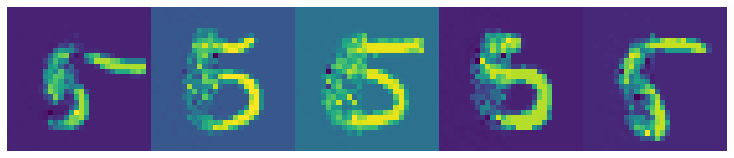

Epoch: 2000/4000 Loss: -2047.7855


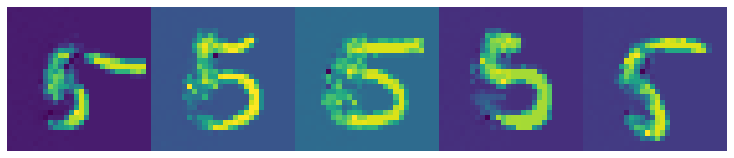

Epoch: 3000/4000 Loss: -2099.0056


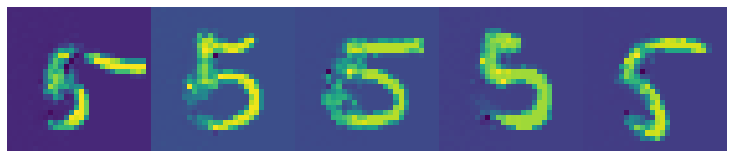

Epoch: 4000/4000 Loss: -2133.6350


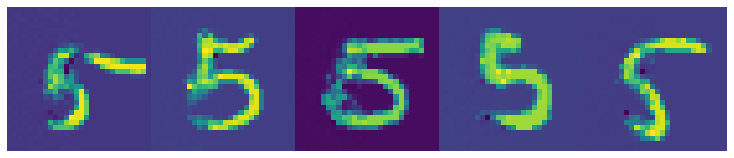

Epoch: 1000/4000 Loss: -1416.1097


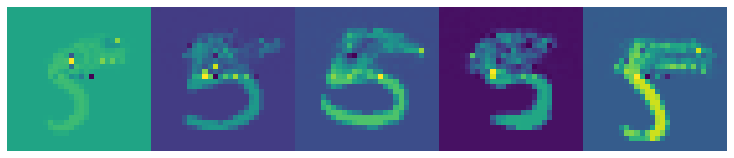

Epoch: 2000/4000 Loss: -1807.2059


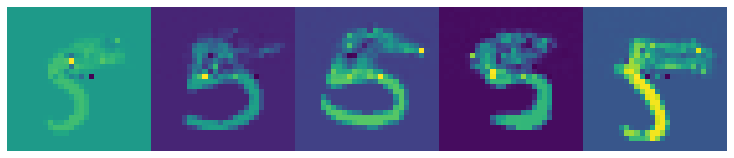

Epoch: 3000/4000 Loss: -1913.8912


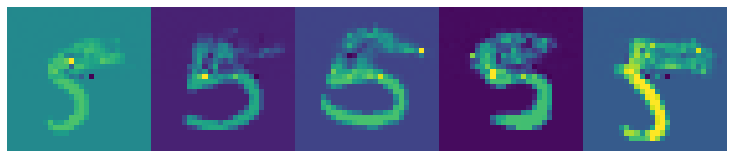

Epoch: 4000/4000 Loss: -1949.4762


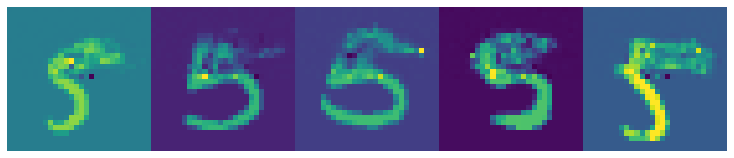

Epoch: 1000/4000 Loss: -1607.3484


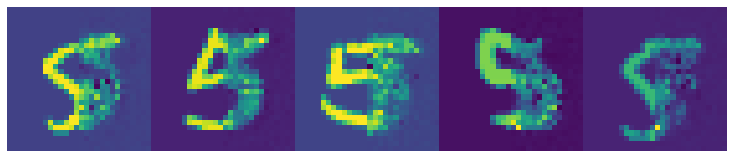

Epoch: 2000/4000 Loss: -1810.6549


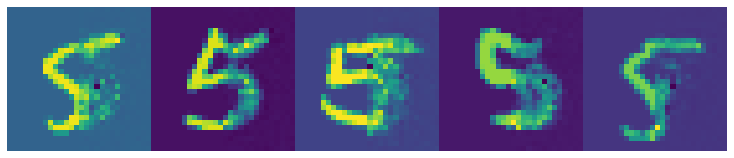

Epoch: 3000/4000 Loss: -1937.1227


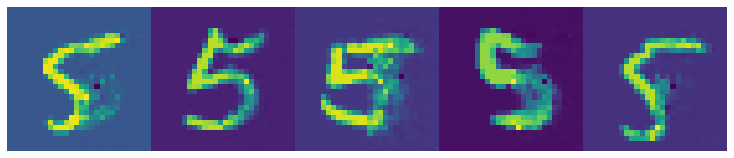

Epoch: 4000/4000 Loss: -2021.4521


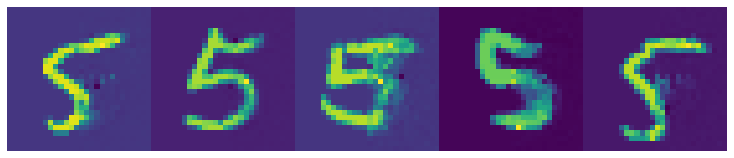

Epoch: 1000/4000 Loss: -1778.7494


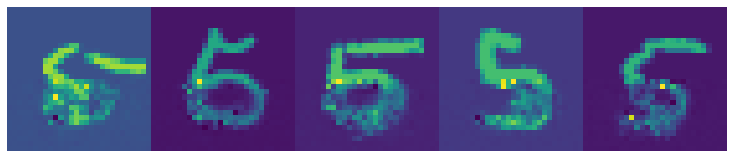

Epoch: 2000/4000 Loss: -1928.4016


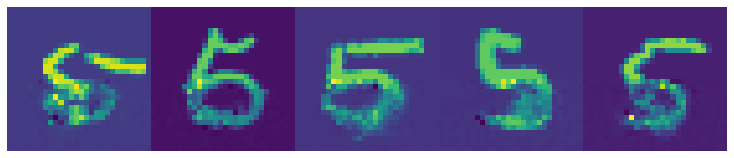

Epoch: 3000/4000 Loss: -1977.6547


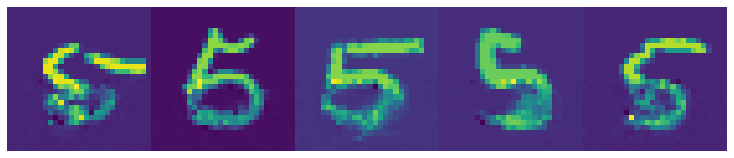

Epoch: 4000/4000 Loss: -2003.9244


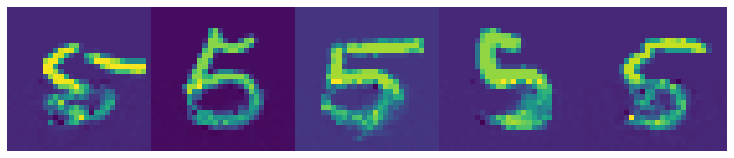

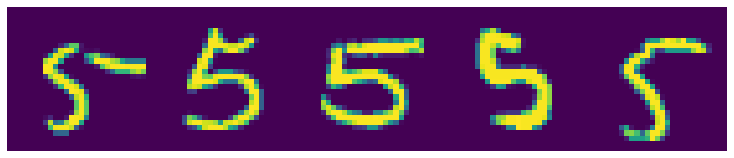

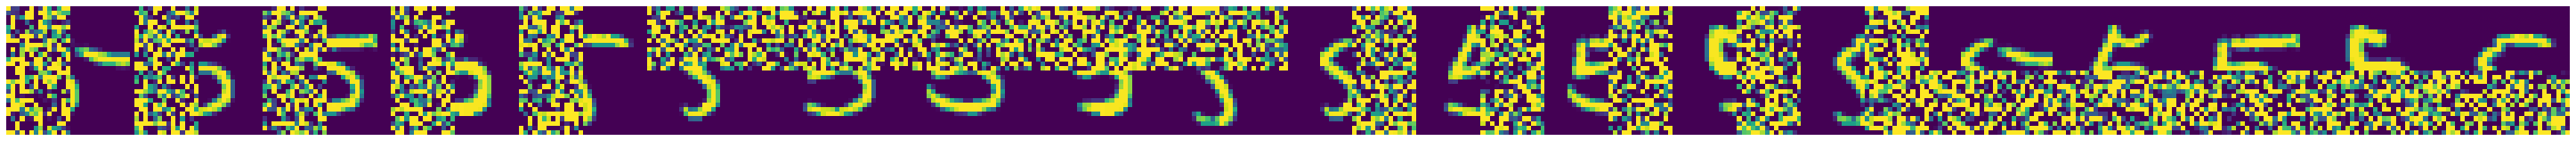

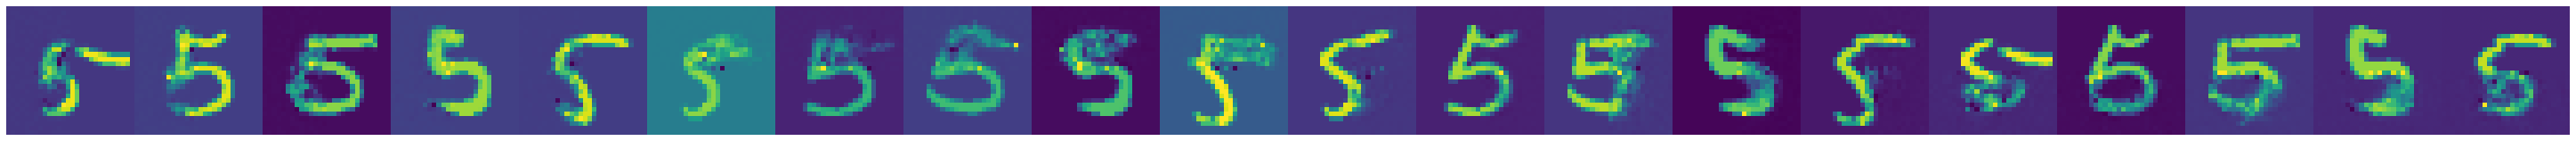

In [ ]:
# Parameters
occlusion_dims = [
    [0, 0, 28, 14],  # Left half
    [0, 0, 14, 28],  # Top half
    [0, 14, 28, 14],  # Right half
    [14, 0, 14, 28]  # Bottom half
]
cat_chunk_dims = [2, 1, 2, 1]
inverse_halves = [True, True, False, False]
num_samples = 5


# Sample and occlude
samples = next(iter(dataloader))[:num_samples].to(device)
occluded = torch.cat([occlude(samples, occ_dim) for occ_dim in occlusion_dims])


# Inpaint
model.eval()
occluded_inpaint = occluded.clone().view(len(occlusion_dims), num_samples, 28, 28)
inpainted = torch.cat([
    inpaint(occ, occ_dim, cat_chunk_dim, inverse) 
    for occ, occ_dim, cat_chunk_dim, inverse 
    in zip(occluded_inpaint, occlusion_dims, cat_chunk_dims, inverse_halves)
])

# Display final samples, occluded samples and results
plot(samples)
plot(occluded)
plot(inpainted)

## Report

### Network architecture

Optimal number of Coupling Layers seemed to be 8 or 10. Networks with number of layers lower than 8 were giving worse looking samples.  
I used two distinct networks for `s` and `t` calcualtion. Those networks have only 3 layers and max layer size is 2048. I also used single batch norm for better convergence.  Such configuration was giving results that were good enough and in the same time it allowed for fast training.  
It was also important to NOT use batch norm on last layer of fully connected network because it was leading to terrible results.


### Hyperparameters

Learning rate of `5e-4` seemed to be optimal. Usually values between `1e-4` and `1e-3` were fine. 


### Loss

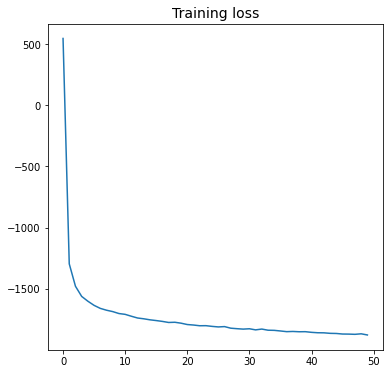

In [ ]:
plt.figure(figsize=(6, 6))
plt.title('Training loss', fontdict={"size": 14})
plt.plot(loss_per_epoch)
plt.show()

### Samples

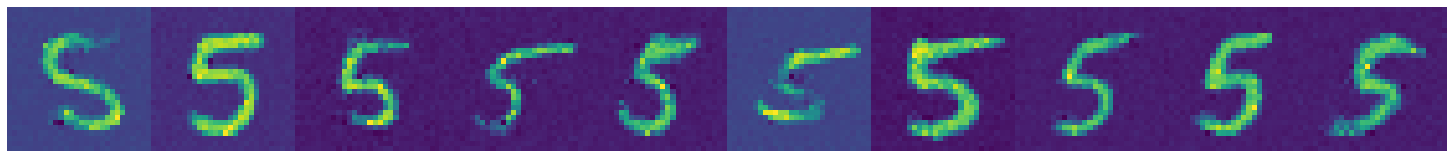

In [ ]:
samples, _ = model.sample(10)
plot(samples)